In [1]:
MODEL_DIRS = [
"/content/drive/Shared drives/CMB - corpora/Chest_x-ray_report_Jan2020/Guide_MIMIC_Transfer/DenseNetTransferPALA/model-001-0.137039-0.144679.h5",
"/content/drive/Shared drives/CMB - corpora/Chest_x-ray_report_Jan2020/Guide_MIMIC_Transfer/DenseNetTransferPALA/model1-012-0.123528-0.137227.h5",
"/content/drive/Shared drives/CMB - corpora/Chest_x-ray_report_Jan2020/Guide_MIMIC_Transfer/DenseNetTransferPALA/model2-001-0.133792-0.141935.h5"
]

LABELS = ["Atelectasis", "Cardiomegaly", "Consolidation","Edema", "Enlarged Cardiomediastinum","Fracture","Lung Lesion","Lung Opacity","No Finding","Pleural Effusion","Pleural Other","Pneumonia","Pneumothorax","Support Devices"]

BS=256
WK=5
SELECTED_VIEW = 'pa_la'

In [2]:
import tensorflow as tf
from sklearn.metrics import roc_curve
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import csv

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data pipeline

### TFrecord

In [3]:
def augment_img_wot(image):
  image = tf.image.resize(image, [264,264])
  image = tf.image.crop_to_bounding_box(image, 20,20, 224,224)
  return image

In [4]:
def read_tfrecord(example, output_mode='both'):
    features = {
        "image_front": tf.io.FixedLenFeature([], tf.string),
        "image_side": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.VarLenFeature(tf.float32),  
        "view": tf.io.FixedLenFeature([], tf.string),
        "select": tf.io.FixedLenFeature([], tf.int64),
        "study_id": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, features)
    label  = tf.reshape(tf.sparse.to_dense(example['label']), [1, 14])
    label = tf.where(tf.math.is_nan(label), tf.ones_like(label) * 0, label)
    label = tf.where(label == -1, tf.ones_like(label) * 0, label)
    label = label[0]

    select = example['select']
    if output_mode=='label':
      return label, select
    elif output_mode=='view_label':
      return label, example['study_id'],example['view'], select
    elif output_mode=='combine_label':
      return (label,label, label), select
    image_front = tf.image.decode_jpeg(example['image_front'], channels=3)
    image_side =  tf.image.decode_jpeg(example['image_side'], channels=3)

    image_front = augment_img_wot(image_front)
    image_side = augment_img_wot(image_side)
    if output_mode=='both':
      return [image_front, image_side], label, select
    elif output_mode=='img_view':
      return [image_front, image_side], example['view'], select
    elif output_mode=='both_view':
      return [image_front, image_side], label, example['view'], select
    else:
      return [image_front, image_side], select

In [5]:
option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

### Image Selection and Preprocessing



In [6]:
def select_image(*record):
  select = record[-1]
  return select == 1

def remove_select(*record):
  return record[:-1]

In [7]:
def select_view_cat(view, *record):
  current_view = record[-1]
  return current_view == view

def remove_view(*record):
  return record[:-1]

In [8]:
def select_view(view, *record):
  record = record[0]
  img = None
  if view == 'frontal':
    img = record[0][0]
  elif view == 'side':
    img = record[0][1]
  else: 
    img = record[0]
  if len(record) == 1:
    return img
  return img, record[1]

In [9]:
def preprocess_image(image):
  image = tf.cast(image, tf.float32)
  image = image / 255.
  image_net_mean = np.array([0.485, 0.456, 0.406])
  image_net_std = np.array([0.229, 0.224, 0.225])
  image = tf.math.subtract(image, image_net_mean)
  image = tf.math.divide(image, image_net_std)
  return image
def preprocess_image_dataset(image, label=None, replicate_label=False):
  image = preprocess_image(image)
  if len(image.shape) ==5:
    image = (image[:,0], image[:,1])
  if label is None:
    return image
  if replicate_label:
    label = (label, label, label)
  return image, label

In [10]:
def choose_view(ds, view):
  ds = ds.filter(lambda *record: select_view_cat(view, *record)).map(remove_view, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  return ds

In [11]:
def choose_selected(ds):
  ds = ds.filter(select_image).map(remove_select, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  return ds

### Data Loader

In [12]:
filenames = tf.io.gfile.glob('/content/drive/My Drive/AG-CNN/tfrecord_test_mul_nr/*.tfrec')
test_dsr = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE)

test_dsrs_img_view = test_dsr.map(lambda record : read_tfrecord(record, 'both_view'), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dsrs_lab_view = test_dsr.map(lambda record : read_tfrecord(record, 'view_label'), num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_dsrs_img_view = choose_selected(test_dsrs_img_view)
test_dsrs_lab_view = choose_selected(test_dsrs_lab_view)

# test_dsrs_img_view = choose_view(test_dsrs_img_view, SELECTED_VIEW).map(lambda *record : select_view('side',record)).batch(BS).map(preprocess_image_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
test_dsrs_img_view = choose_view(test_dsrs_img_view, SELECTED_VIEW).batch(BS).map(preprocess_image_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
test_dsrs_lab_view = choose_view(test_dsrs_lab_view, SELECTED_VIEW).prefetch(tf.data.experimental.AUTOTUNE)

## ROC Threshold

### Crop Function

In [13]:
def find_last_layer(model):
      for layer in reversed(model.layers):
        if len(layer.output_shape) == 4:
          return layer.name
      raise ValueError("Could not find the last convolution layer.")

In [14]:
@tf.function
def get_focus_area(imgs, last_conv_output, threshold = 0.7):
  last_conv_output = tf.math.abs(last_conv_output)
  last_conv_output_max = tf.math.reduce_max(last_conv_output, axis=-1)
  last_conv_output_max_min = tf.math.reduce_min(last_conv_output_max, axis=0)
  last_conv_output_max_max = tf.math.reduce_max(last_conv_output_max, axis=0)
  last_conv_output_norm = (last_conv_output_max - last_conv_output_max_min) / (last_conv_output_max_max-last_conv_output_max_min)
  last_conv_output_cast = tf.cast(last_conv_output_norm >= threshold, tf.float32)
  return last_conv_output_cast

In [15]:
@tf.function
def generate_box(masked):
  positions = tf.where(masked == 1)
  positions = tf.cast(positions, dtype=tf.float32)
  if positions.shape[0] == 0:
    box = tf.constant([0.,0., 1., 1.], dtype=tf.float32)
  else:
    xmin = tf.math.reduce_min(positions[:,0])/6.
    xmax = tf.math.reduce_max(positions[:,0])/6.
    ymin = tf.math.reduce_min(positions[:,1])/6.
    ymax = tf.math.reduce_max(positions[:,1])/6.
    if xmin == xmax:
      xmax = tf.math.minimum(xmin + 0.3, 1.)
    if ymin == ymax:
      ymax = tf.math.minimum(ymin + 0.3, 1.)
    ymin = tf.cond(tf.math.is_inf(ymin), lambda: 0., lambda: ymin)
    xmin = tf.cond(tf.math.is_inf(xmin), lambda: 0., lambda: xmin)
    ymax = tf.cond(tf.math.is_inf(ymax), lambda: 1., lambda: ymax)
    xmax = tf.cond(tf.math.is_inf(xmax), lambda: 1., lambda: xmax)
    box = tf.stack([ymin,xmin, ymax, xmax])
  return box

In [16]:
@tf.function
def generate_box_batch(data):
  imgs, last_conv_output = data
  masks = get_focus_area(imgs, last_conv_output)

  batch_size = tf.shape(imgs)[0]
  boxes = tf.TensorArray(tf.float32, size=batch_size)
  for i in range(batch_size):
    boxes.write(i, generate_box(masks[i]))
  boxes = boxes.stack()
  return crop_imgs(imgs, boxes, batch_size)

In [17]:
@tf.function
def crop_imgs(imgs, boxes, bs=BS, labels=None):
  idxs = tf.range(bs)
  cropped_images = tf.image.crop_and_resize(imgs, boxes, idxs, (224,224), method='nearest')
  if labels is None:
    return cropped_images
  return cropped_images, labels

### Model Segregation

In [18]:
def segregate_model(full_model):
  outputs = full_model.outputs[1]
  return Model(inputs=full_model.inputs, outputs=outputs)

In [19]:
test_label = list(test_dsrs_lab_view)
test_id = tf.stack(np.array(test_label)[:,1]).numpy()
test_label = tf.stack(np.array(test_label)[:,0]).numpy()

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import DenseNet121

In [21]:
global_model = DenseNet121(include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
local_model = DenseNet121(include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [22]:
def createMergeModel(global_model, local_model, suffix):
  global_last_conv_layer = find_last_layer(global_model)
  global_last_conv_layer_output=global_model.get_layer(global_last_conv_layer).output
  
  focus_layer = Lambda(generate_box_batch)([global_model.layers[0].output,global_last_conv_layer_output])

  local_last_conv_layer = find_last_layer(local_model)
  local_last_conv_layer_output=local_model.get_layer(local_last_conv_layer).output

  tmp_local_model = Model(inputs=local_model.input, outputs=local_last_conv_layer_output)

  local_branch = tmp_local_model(focus_layer)
  local_branch = GlobalAveragePooling2D()(local_branch)

  global_branch = GlobalAveragePooling2D()(global_last_conv_layer_output)

  merge_branch = Concatenate(axis=-1, name='concatenate_1')([global_branch, local_branch])
  merge_branch = Dense(14, activation="sigmoid")(merge_branch)

  model = Model(inputs=global_model.input, outputs=merge_branch)

  for layer in model.layers:
    layer._name = layer.name + suffix
  return model

In [ ]:
front_model = createMergeModel(global_model, local_model, "_front")

In [23]:
side_model = createMergeModel(global_model, local_model, "_side")

In [24]:
front_model = DenseNet121(include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
def createMultiModel(front_model, side_model):
  front_output = front_model.get_layer('concatenate_1_front').output

  side_output=side_model.output
  side_output = GlobalAveragePooling2D()(side_output)
  # side_output = side_model.get_layer('global_average_pooling2d_2_side').output

  merge_branch = Concatenate(axis=-1)([front_output, side_output])
  merge_branch = Dense(14, activation="sigmoid")(merge_branch)

  model = Model(inputs=[front_model.input, side_model.input], outputs=merge_branch)
  return model

In [25]:
def createMultiModel(front_model, side_model):
  side_output = side_model.get_layer('concatenate_1_side').output

  front_output = front_model.output
  front_output = GlobalAveragePooling2D()(front_output)
  # side_output = side_model.get_layer('concatenate_1_side').output

  merge_branch = Concatenate(axis=-1)([front_output, side_output])
  merge_branch = Dense(14, activation="sigmoid")(merge_branch)

  model = Model(inputs=[front_model.input, side_model.input], outputs=merge_branch)
  return model

In [26]:
model = createMultiModel(front_model, side_model)

In [ ]:
model = side_model
model.load_weights('/content/drive/Shared drives/CMB - corpora/Chest_x-ray_report_Jan2020/Guide_MIMIC_AGCNN/AGCNNMerge/DenseNetCom(PA)LA/model1-002-0.141487-0.143602.h5')

In [27]:
model.load_weights('/content/drive/My Drive/AGCNNMulti/DenseNetComPALA2/model1-003-0.118767-0.139658.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shared drives/CMB - corpora/Chest_x-ray_report_Jan2020/Guide_MIMIC_OGR_Baseline_BS32/DenseNetPALABaseline/model2-002-0.129063-0.141301.h5')

In [ ]:
model = segregate_model(model)

In [28]:
pred_tmp = model.predict(test_dsrs_img_view, use_multiprocessing= True, workers = WK, verbose=1)
bt = []
for j in range(14):
  fpr, tpr, thresholds = roc_curve(test_label[:,j], pred_tmp[:,j])
  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]
  bt.append(optimal_threshold)

34/34 [==============================] - 41s 1s/step


In [33]:
df = pd.DataFrame(pred_tmp, columns=LABELS)

In [34]:
bt

[0.05522681,
 0.03911592,
 0.01994714,
 0.020189285,
 0.0098689,
 0.015211233,
 0.02851431,
 0.12690672,
 0.60314924,
 0.049650423,
 0.0045618135,
 0.056075923,
 0.008957875,
 0.02539661]

In [ ]:
test_label[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

In [35]:
df['study_id'] = np.array(test_id)

In [ ]:
df[df['study_id'] == 52108729]

,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,study_id
186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,52108729


In [29]:
label_merge = pd.read_csv('/content/drive/My Drive/AG-CNN/dataset/test_set_merge.csv')

In [30]:
pa_la = label_merge[(label_merge['view'] == 'pa_la') & (label_merge['select'] == True)]

In [31]:
pa_la.reset_index(inplace=True)

In [36]:
result_merge = pd.merge(df, pa_la, how='inner', on='study_id')

In [ ]:
result_merge.head()

,Atelectasis_x,Cardiomegaly_x,Consolidation_x,Edema_x,Enlarged Cardiomediastinum_x,Fracture_x,Lung Lesion_x,Lung Opacity_x,No Finding_x,Pleural Effusion_x,Pleural Other_x,Pneumonia_x,Pneumothorax_x,Support Devices_x,study_id,index,Unnamed: 0,dicom_id,subject_id,ViewPosition,Atelectasis_y,Cardiomegaly_y,Consolidation_y,Edema_y,Enlarged Cardiomediastinum_y,Fracture_y,Lung Lesion_y,Lung Opacity_y,No Finding_y,Pleural Effusion_y,Pleural Other_y,Pneumonia_y,Pneumothorax_y,Support Devices_y,path,frontal,side,view,select
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,51028969,1933,358855,2a4446fb-ebb3f744-4d601a14-9b2f15a8-a125d4ce,19526366,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,/content/drive/My Drive/mimic-cxr/images512/p1...,/content/drive/My Drive/mimic-cxr/images512/p1...,/content/drive/My Drive/mimic-cxr/images512/p1...,pa_la,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,50000936,3,75474,1b4edfd9-223f91d2-eb1ec8da-f98e2968-15ead25f,12008045,LATERAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,/content/drive/My Drive/mimic-cxr/images512/p1...,/content/drive/My Drive/mimic-cxr/images512/p1...,/content/drive/My Drive/mimic-cxr/images512/p1...,pa_la,1
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,51029431,1934,247667,87276faf-997b663c-56fd14dd-8e00ef27-ec21f411,16564945,LATERAL,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,/content/drive/My Drive/mimic-cxr/images512/p1...,/content/drive/My Drive/mimic-cxr/images512/p1...,/content/drive/My Drive/mimic-cxr/images512/p1...,pa_la,1
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,50001481,4,221570,02d065af-d0785395-162a5490-e0e1143e-d24656af,15868528,LATERAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,/content/drive/My Drive/mimic-cxr/images512/p1...,/content/drive/My Drive/mimic-cxr/images512/p1...,/content/drive/My Drive/mimic-cxr/images512/p1...,pa_la,1
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,51029604,1935,48716,6ac1633d-9bc91d07-f5ad71f2-8347ef78-d8ec90cb,11315261,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/content/drive/My Drive/mimic-cxr/images512/p1...,/content/drive/My Drive/mimic-cxr/images512/p1...,/content/drive/My Drive/mimic-cxr/images512/p1...,pa_la,1


In [37]:
result_merge.to_csv('/content/drive/My Drive/AG-CNNPALA2_merge.csv', header=True)

In [ ]:
result_merge[(result_merge['Edema_x'] == 0) & ((result_merge['Edema_y'] == 0|  (result_merge['Edema_y'].isnull()))) ]['frontal'].iloc[20]

'/content/drive/My Drive/mimic-cxr/images512/p12/p12376215/s53198522/96f25e5c-a1cd71c6-56eb4d0b-971504bf-6fe47db5.png'

In [ ]:
len(result_merge[(result_merge['Edema_x'] == 1) & ((result_merge['Edema_y'] == 0) |  (result_merge['Edema_y'].isnull())) ]['frontal'])

1015

In [ ]:
len(result_merge[ ((result_merge['Edema_y'] == 1)|  (result_merge['Edema_y'].isnull())) ]['frontal'])

7968

In [ ]:
pa_la.head()

In [ ]:
telen(pa_la[(df['Atelectasis'] > bt[0]) & (pa_la['Atelectasis'] == 1)])

176

In [ ]:
len(pa_la[(pa_la['Atelectasis'] == 1)])

647

In [32]:
for j in range(14):
    fpr, tpr, thresholds = roc_curve(test_label[:,j], pred_tmp[:,j])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    pred_tmp[:,j] = (pred_tmp[:,j] >= optimal_threshold).astype(int)

In [ ]:
pred = np.zeros((len(MODEL_DIRS),test_label.shape[0], test_label.shape[1]))
for i in range(len(MODEL_DIRS)):
  model = tf.keras.models.load_model(MODEL_DIRS[i])
  # model = createMultiModel(front_model, side_model)
  # model.load_weights(MODEL_DIRS[i])
  # model = segregate_model(model)
  pred_tmp = model.predict(test_dsrs_img_view, use_multiprocessing= True, workers = WK, verbose=1)
  for j in range(14):
    fpr, tpr, thresholds = roc_curve(test_label[:,j], pred_tmp[:,j])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    pred_tmp[:,j] = (pred_tmp[:,j] >= optimal_threshold).astype(int)
  pred[i] = pred_tmp

34/34 [==============================] - 37s 1s/step


In [ ]:
def get_mode(x):
    values, counts = np.unique(x, return_counts=True, axis=0)
    m = counts.argmax()
    return values[m]

In [ ]:
mode = get_mode(pred)

In [ ]:
mode = np.genfromtxt("/content/drive/My Drive/AG-CNN/PA(LA)mode.csv", delimiter=',')

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_matrix(conf_mat):
  df_cm = pd.DataFrame(conf_mat)
  sns.heatmap(df_cm, annot=True, cbar=False)

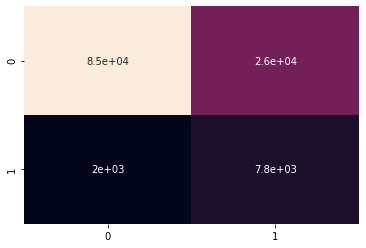

In [ ]:
cfs_matrix = confusion_matrix(np.array(test_label).flatten(), np.array(mode).flatten())
plot_matrix(cfs_matrix)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


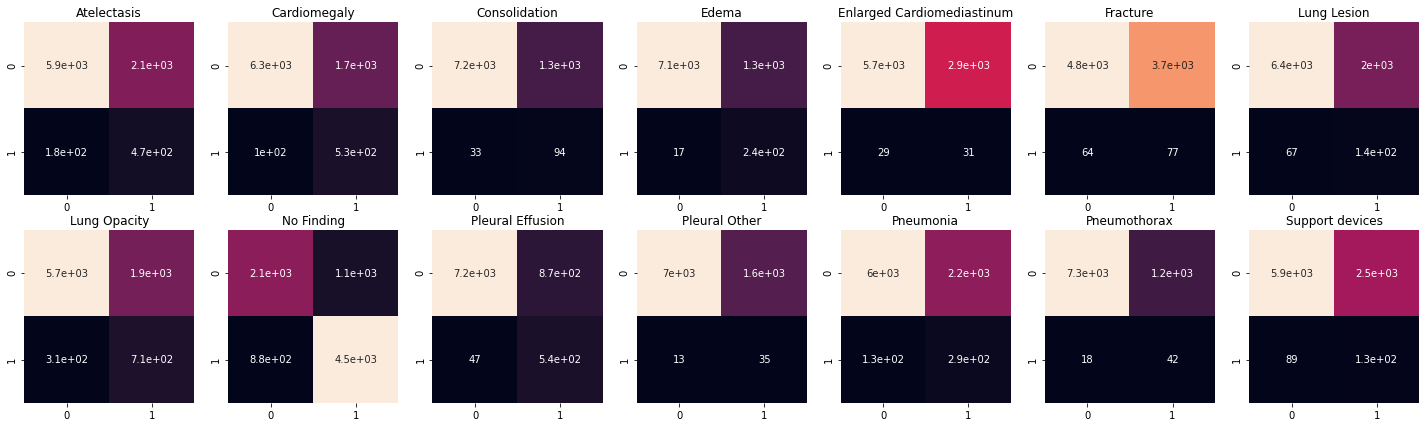

In [ ]:
fig = plt.figure(figsize=(25,7))

for i in range(14):
  cfs_matrix = confusion_matrix(np.array(test_label[:,i]).flatten(), np.array(mode[:,i]).flatten())
  plt.subplot(2, 7, i+1)
  plot_matrix(cfs_matrix)
  plt.subplot(2, 7, i+1).set_title(LABELS[i])

# fig.text(0.5, 0.04, 'Prediction', ha='center')
# fig.text(0.04, 0.5, 'Truth', va='center', rotation='vertical')

In [ ]:
np.savetxt("/content/drive/My Drive/AG-CNN/TransferPALAmode.csv", mode, delimiter=",")

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
precisions = np.zeros(14)
recalls = np.zeros(14)
f1 = np.zeros(14)

In [ ]:
data = np.genfromtxt('/content/drive/My Drive/AG-CNN/AGCNNPALAmode.csv', delimiter=',')

In [ ]:
for i in range(14):
  p, r, f,_ = precision_recall_fscore_support(np.array(test_label[:,i]).flatten(), np.array(pred_tmp[:,i]).flatten(), average='macro')
  precisions[i] = p 
  recalls[i] = r
  f1[i] = f

In [ ]:
recalls

array([0.76061308, 0.82416154, 0.79467414, 0.89698024, 0.62384286,
       0.62991782, 0.71339121, 0.73249332, 0.75736015, 0.87820269,
       0.76018119, 0.71195116, 0.85365616, 0.65838902])

In [ ]:
with open("/content/drive/My Drive/test.csv", 'a') as fp:
  writer = csv.writer(fp, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  writer.writerow(precisions)
  writer.writerow(recalls)
  writer.writerow(f1)

In [ ]:
transfer = np.genfromtxt('/content/drive/My Drive/AG-CNN/TransferPALAmode.csv', delimiter=',')
ogr = np.genfromtxt('/content/drive/My Drive/AG-CNN/OGR+PALAmode.csv', delimiter=',')
front = np.genfromtxt('/content/drive/My Drive/AG-CNN/PA(LA)mode.csv', delimiter=',')
side = np.genfromtxt('/content/drive/My Drive/AG-CNN/(PA)LAmode.csv', delimiter=',')
pala = np.genfromtxt('/content/drive/My Drive/AG-CNN/PALAmode.csv', delimiter=',')

In [ ]:
transfer_df = pd.DataFrame(data=transfer, columns=LABELS)
ogr_df = pd.DataFrame(data=ogr, columns=LABELS)
front_df = pd.DataFrame(data=front, columns=LABELS)
side_df = pd.DataFrame(data=side, columns=LABELS)
pala_df = pd.DataFrame(data=pala, columns=LABELS)
label_df = pd.DataFrame(data=test_label, columns=LABELS)

In [ ]:
merge_df = label_df.join(transfer_df,rsuffix='_transfer').join(ogr_df,rsuffix='_ogr').join(front_df,rsuffix='_front').join(side_df,rsuffix='_side').join(pala_df,rsuffix='_pala')

In [ ]:
merge_df.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support devices,Atelectasis_transfer,Cardiomegaly_transfer,Consolidation_transfer,Edema_transfer,Enlarged Cardiomediastinum_transfer,Fracture_transfer,Lung Lesion_transfer,Lung Opacity_transfer,No Finding_transfer,Pleural Effusion_transfer,Pleural Other_transfer,Pneumonia_transfer,Pneumothorax_transfer,Support devices_transfer,Atelectasis_ogr,Cardiomegaly_ogr,Consolidation_ogr,Edema_ogr,Enlarged Cardiomediastinum_ogr,Fracture_ogr,Lung Lesion_ogr,Lung Opacity_ogr,No Finding_ogr,Pleural Effusion_ogr,Pleural Other_ogr,Pneumonia_ogr,...,Consolidation_front,Edema_front,Enlarged Cardiomediastinum_front,Fracture_front,Lung Lesion_front,Lung Opacity_front,No Finding_front,Pleural Effusion_front,Pleural Other_front,Pneumonia_front,Pneumothorax_front,Support devices_front,Atelectasis_side,Cardiomegaly_side,Consolidation_side,Edema_side,Enlarged Cardiomediastinum_side,Fracture_side,Lung Lesion_side,Lung Opacity_side,No Finding_side,Pleural Effusion_side,Pleural Other_side,Pneumonia_side,Pneumothorax_side,Support devices_side,Atelectasis_pala,Cardiomegaly_pala,Consolidation_pala,Edema_pala,Enlarged Cardiomediastinum_pala,Fracture_pala,Lung Lesion_pala,Lung Opacity_pala,No Finding_pala,Pleural Effusion_pala,Pleural Other_pala,Pneumonia_pala,Pneumothorax_pala,Support devices_pala
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# result = merge_df[(merge_df['Pleural Effusion_front']!=merge_df['Pleural Effusion']) & (merge_df['Pleural Effusion_transfer']==merge_df['Pleural Effusion'])& (merge_df['Pleural Effusion_transfer']==1)]
result = merge_df[(merge_df['Pleural Other_front']!=merge_df['Pleural Other_transfer'])]
result

,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support devices,Atelectasis_transfer,Cardiomegaly_transfer,Consolidation_transfer,Edema_transfer,Enlarged Cardiomediastinum_transfer,Fracture_transfer,Lung Lesion_transfer,Lung Opacity_transfer,No Finding_transfer,Pleural Effusion_transfer,Pleural Other_transfer,Pneumonia_transfer,Pneumothorax_transfer,Support devices_transfer,Atelectasis_ogr,Cardiomegaly_ogr,Consolidation_ogr,Edema_ogr,Enlarged Cardiomediastinum_ogr,Fracture_ogr,Lung Lesion_ogr,Lung Opacity_ogr,No Finding_ogr,Pleural Effusion_ogr,Pleural Other_ogr,Pneumonia_ogr,...,Consolidation_front,Edema_front,Enlarged Cardiomediastinum_front,Fracture_front,Lung Lesion_front,Lung Opacity_front,No Finding_front,Pleural Effusion_front,Pleural Other_front,Pneumonia_front,Pneumothorax_front,Support devices_front,Atelectasis_side,Cardiomegaly_side,Consolidation_side,Edema_side,Enlarged Cardiomediastinum_side,Fracture_side,Lung Lesion_side,Lung Opacity_side,No Finding_side,Pleural Effusion_side,Pleural Other_side,Pneumonia_side,Pneumothorax_side,Support devices_side,Atelectasis_pala,Cardiomegaly_pala,Consolidation_pala,Edema_pala,Enlarged Cardiomediastinum_pala,Fracture_pala,Lung Lesion_pala,Lung Opacity_pala,No Finding_pala,Pleural Effusion_pala,Pleural Other_pala,Pneumonia_pala,Pneumothorax_pala,Support devices_pala
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
14,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8617,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.

In [ ]:
result.iloc[:,0:14].apply(pd.Series.value_counts)

,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support devices
0.0,1728,1756,1986,1891,2021,2000,1987,1640,1267,1750,2022,1865,2014,1952
1.0,307,279,49,144,14,35,48,395,768,285,13,170,21,83


In [ ]:
result.iloc[:,14:28].apply(pd.Series.value_counts)

,Atelectasis_transfer,Cardiomegaly_transfer,Consolidation_transfer,Edema_transfer,Enlarged Cardiomediastinum_transfer,Fracture_transfer,Lung Lesion_transfer,Lung Opacity_transfer,No Finding_transfer,Pleural Effusion_transfer,Pleural Other_transfer,Pneumonia_transfer,Pneumothorax_transfer,Support devices_transfer
0.0,282,393,335,405,251,258,516,189,604,513,178,217,402,205
1.0,418,307,365,295,449,442,184,511,96,187,522,483,298,495


In [ ]:
result.iloc[:,42:56].apply(pd.Series.value_counts)

,Atelectasis_front,Cardiomegaly_front,Consolidation_front,Edema_front,Enlarged Cardiomediastinum_front,Fracture_front,Lung Lesion_front,Lung Opacity_front,No Finding_front,Pleural Effusion_front,Pleural Other_front,Pneumonia_front,Pneumothorax_front,Support devices_front
0.0,304,389,316,386,282,329,303,209,603,187,495,289,529,452
1.0,396,311,384,314,418,371,397,491,97,513,205,411,171,248


In [ ]:
aggre = result.iloc[:,0:14].apply(pd.Series.value_counts).values
ratio = aggre[1] / (aggre[1] + aggre[0])
ratio

array([0.15085995, 0.13710074, 0.02407862, 0.07076167, 0.00687961,
       0.01719902, 0.02358722, 0.19410319, 0.37739558, 0.14004914,
       0.00638821, 0.08353808, 0.01031941, 0.04078624])

In [ ]:
aggre = result.iloc[:,14:28].apply(pd.Series.value_counts).values
ratio = aggre[1] / (aggre[1] + aggre[0])
ratio

array([0.65405405, 0.42113022, 0.47911548, 0.35823096, 0.71253071,
       0.70515971, 0.17542998, 0.81818182, 0.15675676, 0.28943489,
       0.98083538, 0.6987715 , 0.4029484 , 0.7046683 ])

In [ ]:
aggre = result.iloc[:,42:56].apply(pd.Series.value_counts).values
ratio = aggre[1] / (aggre[1] + aggre[0])
ratio

array([0.55528256, 0.39312039, 0.4019656 , 0.34496314, 0.5041769 ,
       0.51154791, 0.45995086, 0.5995086 , 0.28501229, 0.33513514,
       0.01916462, 0.47764128, 0.17395577, 0.26732187])

In [ ]:
aggre = merge_df.iloc[:,0:14].apply(pd.Series.value_counts).values
ratio = aggre[1] / (aggre[1] + aggre[0])
ratio

array([0.07520278, 0.07323291, 0.01471611, 0.02966396, 0.00695249,
       0.01633835, 0.02363847, 0.1184241 , 0.6221321 , 0.06755504,
       0.00556199, 0.04866744, 0.00695249, 0.02502897])

In [ ]:
aggre = merge_df.iloc[:,70:84].apply(pd.Series.value_counts).values
ratio = aggre[1] / (aggre[1] + aggre[0])
ratio

array([0.20220162, 0.23070684, 0.21830823, 0.18539977, 0.39165701,
       0.44542294, 0.25631518, 0.29478563, 0.6198146 , 0.16604867,
       0.10625724, 0.36639629, 0.15782155, 0.23174971])

In [ ]:
result1 = result.iloc[:,14:28]
result1.columns = LABELS
result2 = result.iloc[:,56:70]
result2.columns = LABELS

result_concat = pd.concat([result1, result2], axis=0)

In [ ]:
result_concat

In [ ]:
from sklearn.manifold import TSNE
principalComponents_result = TSNE().fit_transform(result_concat)
principal_result_Df = pd.DataFrame(data = principalComponents_result
             , columns = ['principal component 1', 'principal component 2'])

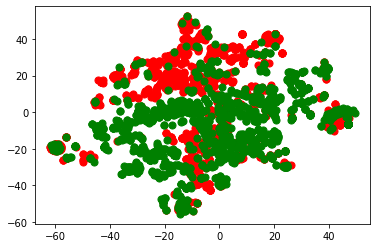

In [ ]:
plt.scatter(principal_result_Df.iloc[:1701, 0]
               , principal_result_Df.iloc[:1701, 1], c = 'r', s = 50)
plt.scatter(principal_result_Df.iloc[1701:, 0]
               , principal_result_Df.iloc[1701:, 1], c = 'g', s = 50)